# iNethi Traffic Analysis

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import calendar
from scipy.stats import describe

import seaborn as sns
#sns.set(style="ticks", palette="pastel")

plt.style.use('default')

def dataDescribe(df):
    
    df_mean = df.groupby(df.index).mean()
    df_median = df.groupby(df.index).median()
    df_std = df.groupby(df.index).std()
    df_sum = df.groupby(df.index).sum()
    
    months = df.index.unique()
    
    df_desc = pd.DataFrame(columns=['Month','Mean','Median','Std Dev','Variance','Skewness','Kurtosis','Min','Max','Sum'])
    for m in months:
        d = describe(df.loc[df.index==m], axis=0)
        median = df_median[df_median.index==m].bytes[0]
        std = df_std[df_std.index==m].bytes[0]
        total = df_sum[df_sum.index==m].bytes[0] 
        df_desc = df_desc.append({'Month':m,
                                            'Mean':d.mean[0],
                                            'Median': median,
                                            'Std Dev':std,
                                            'Variance': d.variance[0],
                                            'Skewness': d.skewness[0],
                                            'Kurtosis': d.kurtosis[0],
                                            'Min': d.minmax[0][0],
                                            'Max': d.minmax[1][0],
                                            'Sum': total
                                           } , ignore_index=True)

    return df_desc


## Overall Traffic stats
Traffic is coming from three main locations: mesh, school and servers. 

In [3]:
df_stats = pd.read_csv('data/stats/traffic_stats.csv', parse_dates=True)

In [68]:
df_stats.head()

,date,location,protocol,src_ip,dest_ip,download_frames,download_bytes,upload_frames,upload_bytes,total_frames,total_bytes,relative_start,duration
0,2019-08-26 12:30:00,mesh,tcp,10.10.161.48:51388,10.10.0.1:8002,114,167894,179,13243,293,181137,2057.856614,3.6265
1,2019-08-26 12:30:00,mesh,tcp,10.10.173.219:32972,10.10.0.1:8002,152,190674,141,11152,293,201826,2270.564280,2.2383
2,2019-08-26 12:30:00,mesh,tcp,10.10.161.48:51424,10.10.0.1:8002,127,187576,159,11467,286,199043,2106.449946,2.1058
3,2019-08-26 12:30:00,mesh,tcp,10.10.167.54:34901,10.10.0.1:8002,137,194028,127,9437,264,203465,1216.615621,3.5621
4,2019-08-26 12:30:00,mesh,tcp,10.10.167.54:35011,10.10.0.1:8002,132,183562,126,9260,258,192822,1316.123455,2.4173


In [4]:
df_udp = df_stats.loc[df_stats.protocol=='udp']
df_tcp = df_stats.loc[df_stats.protocol=='tcp']

In [5]:
df_total = df_stats.groupby('date')['date','download_bytes', 'upload_bytes'].sum()
df_total.head()

,download_bytes,upload_bytes
date,,
2019-07-29 17:35:23,201354,157683
2019-07-29 17:56:02,61425430,11137756
2019-07-29 18:56:02,350158577,24938679
2019-07-29 19:56:02,576221228,40555215
2019-07-29 19:56:03,812172,643600


In [6]:
df_total.index = pd.to_datetime(df_total.index, dayfirst=False) 

In [7]:
df_total = df_total.resample('D').sum()

In [8]:
df_total['download_bytes'] = df_total.apply(lambda x: x.download_bytes/1e+9, axis=1)
df_total['upload_bytes'] = df_total.apply(lambda x: x.upload_bytes/1e+9, axis=1)


In [9]:
df_total['month'] = pd.DatetimeIndex(df_total.index).month
df_total['month'] = df_total['month'].apply(lambda x: calendar.month_abbr[x])

In [10]:
df_total = df_total[df_total.month != 'Jul']
df_total = df_total.set_index('month')

In [11]:
df_total_download = df_total.iloc[:,[0]]
df_total_upload = df_total.iloc[:,[1]]

In [12]:
df_total_download = df_total_download.rename(columns={"download_bytes": "bytes"})
df_total_upload = df_total_upload.rename(columns={"upload_bytes": "bytes"})

In [13]:
df_total_upload.head()

,bytes
month,
Aug,0.736838
Aug,0.596550
Aug,0.677159
Aug,0.546311
Aug,0.461788


### Descriptive statistics of daily IP data upload traffic in GB

In [14]:
dataDescribe(df_total_upload).set_index('Month').T

Month,Aug,Sep,Oct
Mean,0.645751,0.814197,0.464104
Median,0.677159,0.662563,0.398212
Std Dev,0.417203,0.653246,0.177019
Variance,0.174059,0.426731,0.031336
Skewness,-0.169892,3.759795,1.200722
Kurtosis,-0.678895,14.852591,0.883922
Min,0.000000,0.202088,0.232362
Max,1.504647,3.887980,0.925446
Sum,20.018267,24.425899,9.282073


In [15]:
dataDescribe(df_total_download).set_index('Month').T

Month,Aug,Sep,Oct
Mean,5.931447,7.252217,5.439405
Median,6.953376,6.944968,4.363324
Std Dev,3.547000,2.129489,2.520445
Variance,12.581212,4.534723,6.352644
Skewness,-0.715925,0.043364,1.179998
Kurtosis,-0.887896,-0.293431,1.078373
Min,0.000000,2.434725,2.049421
Max,11.133038,11.291630,12.465332
Sum,183.874857,217.566513,108.788093


### Boxplot of download and upload traffic

In [16]:
df_total_download['type'] = "download"
df_total_upload['type'] = "upload"

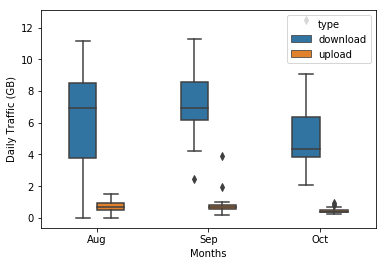

In [17]:
df_merged = pd.concat([df_total_download, df_total_upload])

ax = sns.boxplot(y='bytes', x=df_merged.index, 
                 data=df_merged, 
                 #palette="colorblind",
                 hue='type', width=0.5)

ax.set(xlabel='Months', ylabel='Daily Traffic (GB)')
plt.savefig('plots/box_plot_traffic.pdf')
plt.show()


### Daily traffic pattern - UDP vs TCP

In [123]:
df_download = df_stats.iloc[:,[0,2,6]]
df_download = df_download.groupby(['date','protocol'])['download_bytes'].sum().reset_index()
df_download = df_download.pivot(index='date', columns='protocol', values='download_bytes').reset_index()
df_download.columns = ['date', 'tcp_down','udp_down']

df_upload = df_stats.iloc[:,[0,2,8]]
df_upload = df_upload.groupby(['date','protocol'])['upload_bytes'].sum().reset_index()
df_upload = df_upload.pivot(index='date', columns='protocol', values='upload_bytes').reset_index()
df_upload.columns = ['date', 'tcp_up','udp_up']

df_downup = df_upload.merge(df_download, left_on='date', right_on='date', suffixes=(False, False))
df_downup['download'] = df_downup.tcp_down + df_downup.udp_down
df_downup['upload'] = df_downup.tcp_up + df_downup.udp_up

df_downup.index = pd.to_datetime(df_downup.date, dayfirst=False) 
df_downup = df_downup.resample('D').sum()
df_downup = df_downup[['tcp_up', 'udp_up', 'tcp_down', 'udp_down', 'download', 'upload']].div(1e+9, axis=0)
df_downup = df_downup.reset_index()

In [124]:
df_downup.head()

,date,tcp_up,udp_up,tcp_down,udp_down,download,upload
0,2019-07-29,0.132042,0.032456,1.690148,0.857724,2.547873,0.164498
1,2019-07-30,0.611220,0.053401,7.928463,0.311054,8.239517,0.664620
2,2019-07-31,0.551959,0.056417,6.047372,0.354916,6.402288,0.608375
3,2019-08-01,0.686945,0.049894,7.722831,0.352709,8.075540,0.736838
4,2019-08-02,0.536750,0.059800,6.457490,0.495886,6.953376,0.596550


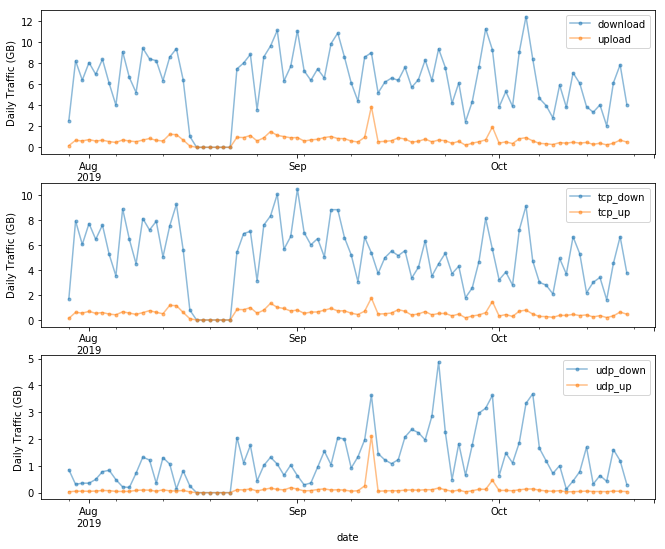

In [126]:
fig, axes = plt.subplots(nrows=3, ncols=1)

df_downup.plot(ax=axes[0], x="date", y=["download", "upload"], kind="line", marker='.', alpha=0.5, linestyle='-', figsize=(11, 9))
df_downup.plot(ax=axes[1], x="date", y=["tcp_down", "tcp_up"], kind="line", marker='.', alpha=0.5, linestyle='-', figsize=(11, 9))
df_downup.plot(ax=axes[2], x="date", y=["udp_down", "udp_up"], kind="line", marker='.', alpha=0.5, linestyle='-', figsize=(11, 9))

for ax in axes:
    ax.set_ylabel('Daily Traffic (GB)')

plt.savefig('plots/daily_traffic_tcp_ucp.pdf')
plt.show()

### Split between mesh, school and servers

In [119]:
df_download = df_stats.iloc[:,[0,1,6]]
df_download = df_download.groupby(['date','location'])['download_bytes'].sum().reset_index()
df_download = df_download.pivot(index='date', columns='location', values='download_bytes').reset_index()
df_download.columns = ['date', 'mesh_down','school_down']

df_upload = df_stats.iloc[:,[0,1,8]]
df_upload = df_upload.groupby(['date','location'])['upload_bytes'].sum().reset_index()
df_upload = df_upload.pivot(index='date', columns='location', values='upload_bytes').reset_index()
df_upload.columns = ['date', 'mesh_up','school_up']

df_downup = df_upload.merge(df_download, left_on='date', right_on='date', suffixes=(False, False))
df_downup['download'] = df_downup.mesh_d + df_downup.school_d
df_downup['upload'] = df_downup.mesh_up + df_downup.school_up 

df_downup.index = pd.to_datetime(df_downup.date, dayfirst=False) 
df_downup = df_downup.resample('D').sum()
df_downup = df_downup[['mesh_d', 'school_d', 'mesh_up', 'school_up','download','upload']].div(1e+9, axis=0)
df_downup = df_downup.reset_index()

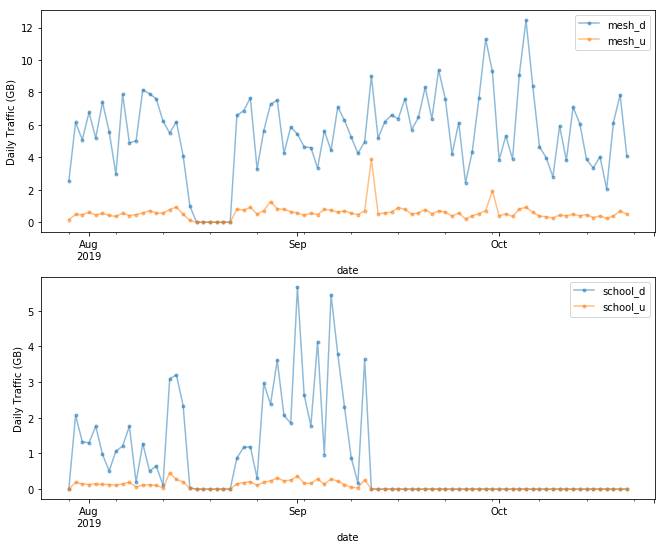

In [122]:
fig, axes = plt.subplots(nrows=2, ncols=1)

df_downup.plot(ax=axes[0], x="date", y=["mesh_d", "mesh_u"], kind="line", marker='.', alpha=0.5, linestyle='-', figsize=(11, 9))
df_downup.plot(ax=axes[1], x="date", y=["school_d", "school_u"], kind="line", marker='.', alpha=0.5, linestyle='-', figsize=(11, 9))

for ax in axes:
    ax.set_ylabel('Daily Traffic (GB)')

plt.savefig('plots/daily_traffic_location.pdf')
plt.show()

### A CDF of the total daily traffic

In [ ]:
df_cc_origin = df1['vantageCC'].drop_duplicates()
df_cc_dest = df2['destCC'].drop_duplicates()

n_bins = 500

fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2)

for index, cc in df_cc_origin.iteritems():
    # plot the cumulative histogram
    array = df1.loc[df1['vantageCC']==cc].iloc[:,[1]].values
    
    ax1.hist(array, n_bins, density=1, histtype='step', range=[0, 500], linewidth=2, 
                           cumulative=True, label=cc)

# tidy up the figure
ax1.grid(True)
ax1.legend(loc='right')
ax1.set_title('RTT by origin country')
ax1.set_xlabel('ms')
ax1.set_ylabel('CDF')

for index, cc in df_cc_dest.iteritems():
    # plot the cumulative histogram
    array = df2.loc[df2['destCC']==cc].iloc[:,[1]].values
    
    ax2.hist(array, n_bins, density=1, histtype='step', range=[0, 500], linewidth=2, 
                           cumulative=True, label=cc)
    
# tidy up the figure
ax2.grid(True)
ax2.legend(loc='right')
ax2.set_title('RTT by destination country')
ax2.set_xlabel('ms')
ax2.set_ylabel('CDF')

plt.savefig("data/plots/cdf_rtt_cc.svg")
plt.show()
